In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import subprocess
%matplotlib inline

In [16]:
SAVEPATH = "graphs/"

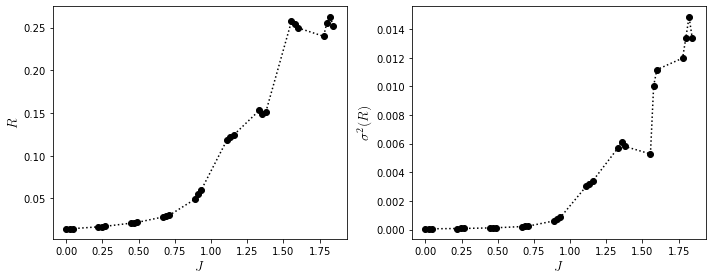

In [28]:
path = "./../data/pd-parts/"
name = "cb7"

nparts = 9


data = np.empty((0,3))
for part in range(nparts):
    datafile = np.loadtxt(path + name + "_part{0}".format(part))
    data = np.append(data, datafile, axis=0)
del datafile

fig, axes = plt.subplots(ncols=2, figsize=(10,4))
axes[0].plot(data[:,0], data[:,1], color="black", marker="o", ls=":")
axes[1].plot(data[:,0], data[:,2], color="black", marker="o", ls=":")

axes[0].set_xlabel(r'$J$', fontsize=14, usetex=True)
axes[0].set_ylabel(r'$R$', fontsize=14, usetex=True)

axes[1].set_ylabel(r'$\sigma^2(R)$', fontsize=14, usetex=True)
axes[1].set_xlabel(r'$J$', fontsize=14, usetex=True)

plt.tight_layout()

plt.savefig(SAVEPATH + name + "_pd.pdf")
plt.show()